   Dummy Policy No  ASSURED_AGE NOMINEE_RELATION     OCCUPATION  \
0                1           20           Mother        Service   
1                2           33          Husband        Service   
2                3           34             Wife  Self-Employed   
3                4           34             Wife        Service   
4                5           54          Husband      Housewife   

  POLICY SUMASSURED     Premium PREMIUMPAYMENTMODE Annual Income  \
0        1,200,000     120,000           Quarterly      420,000    
1          350,000       5,000              Yearly      180,000    
2          350,000       5,000              Yearly      249,000    
3          325,000       5,000              Yearly      360,000    
4          100,000       5,000              Yearly      600,000    

  HOLDERMARITALSTATUS INDIV_REQUIREMENTFLAG  ...  CORRESPONDENCEPOSTCODE  \
0              Single           Non Medical  ...                  816115   
1             Married           Non 

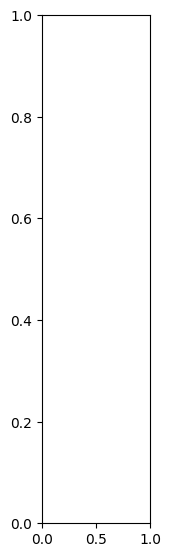

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import lightgbm as lgb
import cv2
import pytesseract
import json

# Load the data
file_path = 'Fraud_data.csv'
data = pd.read_csv(file_path)
print(data.head())

# Drop rows with NaN values
data.dropna(inplace=True)

# Clean and convert the Premium and POLICY SUMASSURED columns
data['Premium'] = data['Premium'].str.replace(',', '').str.strip().astype(float)
data['POLICY SUMASSURED'] = data['POLICY SUMASSURED'].str.replace(',', '').str.strip().astype(float)

# Calculate the Premium to Sum Assured Ratio
data['Premium_to_SumAssured_Ratio'] = data['Premium'] / data['POLICY SUMASSURED']

# Replace inf values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
data.dropna(inplace=True)

# Apply Risk Category Function
def check_risk(ratio, high_ratio_threshold=0.2, low_ratio_threshold=0.01):
    if ratio > high_ratio_threshold:
        return 'High Risk'
    elif ratio < low_ratio_threshold:
        return 'Low Risk'
    else:
        return 'Normal Risk'

data['Risk Category'] = data['Premium_to_SumAssured_Ratio'].apply(check_risk)

# Encode the target variable
label_encoder = LabelEncoder()
data['Fraud Category Encoded'] = label_encoder.fit_transform(data['Fraud Category'])

# Define Features (X) and Target (y)
features = ['Premium', 'POLICY SUMASSURED', 'Premium_to_SumAssured_Ratio']
X = data[features]
y = data['Fraud Category Encoded']

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize Classifiers
rf = RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced')
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')
lgb_model = lgb.LGBMClassifier()

# Train Models
rf.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)

# Anomaly Detection using Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=0)
iso_forest.fit(X_train)

# Function to Predict and Warn
def predict_and_warn(model, new_data):
    probas = model.predict_proba(new_data)
    predictions = model.predict(new_data)
    warnings = []
    for i, proba in enumerate(probas):
        if max(proba) > 0.8:  # Threshold for warning
            warnings.append(f"Warning: High probability of fraud detected for customer {i+1}!")
        else:
            warnings.append(f"Customer {i+1} is safe.")
    return predictions, warnings

# Real-Time Fraud Detection
def real_time_fraud_detection(model, stream_data):
    for data_point in stream_data:
        prediction, warning = predict_and_warn(model, pd.DataFrame([data_point]))
        print(warning)

# SHAP for Model Explainability
try:
    import shap
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(X_val)
    shap.summary_plot(shap_values, X_val)
except ImportError:
    print("SHAP is not installed. Skipping explainability.")
except Exception as e:
    print(f"SHAP Explainability Error: {e}")

# Example new data for prediction
new_data = pd.DataFrame({
    'Premium': [5000, 10000],
    'POLICY SUMASSURED': [50000, 100000],
    'Premium_to_SumAssured_Ratio': [0.1, 0.1]
})

# Predict and Warn for Each Model
rf_predictions, rf_warnings = predict_and_warn(rf, new_data)
print("Random Forest Warnings:")
print(rf_warnings)

# Document Authentication using OCR
def authenticate_document(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return "Error: Image file not found or could not be loaded."
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    text = pytesseract.image_to_string(gray)
    if "AUTHENTIC" in text:
        return "Document is authentic"
    else:
        return "Document is not authentic"

document_status = authenticate_document('path_to_document_image.jpg')
print(document_status)

# Kafka Consumer for Real-Time Streaming
def kafka_stream_processing(model, topic='fraud_detection', server='localhost:9092'):
    try:
        from kafka import KafkaConsumer
        consumer = KafkaConsumer(topic, bootstrap_servers=[server])
        for message in consumer:
            data_point = json.loads(message.value)
            prediction, warning = predict_and_warn(model, pd.DataFrame([data_point]))
            print(warning)
    except ImportError:
        print("Kafka module is not installed.")
    except Exception as e:
        print(f"Kafka Error: {e}")

# Example usage for Kafka
# kafka_stream_processing(rf)
